In [48]:
import numpy as np
from datasets import load_dataset, load_metric
import pandas as pd
import evaluate
import rouge
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import warnings
import torch
warnings.filterwarnings("ignore")

In [2]:
dataset = load_dataset("allenai/multi_lexsum", "v20230518", cache_dir="./data")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'sources', 'sources_metadata', 'summary/long', 'summary/short', 'summary/tiny', 'case_metadata'],
        num_rows: 3177
    })
    validation: Dataset({
        features: ['id', 'sources', 'sources_metadata', 'summary/long', 'summary/short', 'summary/tiny', 'case_metadata'],
        num_rows: 454
    })
    test: Dataset({
        features: ['id', 'sources', 'sources_metadata', 'summary/long', 'summary/short', 'summary/tiny', 'case_metadata'],
        num_rows: 908
    })
})


In [3]:
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [4]:
train_dataset[0]

{'id': 'EE-AL-0045',
 'sources': ['Case 1:05-cv-00530-D Document 1-1 Filed 09/19/2005 Page 1 of 6\n\nIN\n\nTHE\n\nUNITED\n\nSTATES\n\nDISTRICT\n\nFILD COUR T\n\nP19\n\n.05\n\nNl\n\nel\n\n.s\n\nFOR THE SOUTHERN DISTRICT OF ALABAMA\n\nSOUTHERN DIVISION\n\nEQUAL EMPLOYMENT OPPORTUNITY ]\n\nCOMMISSION, ]\n\n] Plaintiff, ] Civil Action No. OSS- 0\'53a -~\n\nv.\n\n]\n\n]\nCOMPLAINT\n\n] HOUSE OF PHILADELPHIA CENTER, INC . ]\n\nJURY TRIAL DEMAND\n\nDefendant .\n\n]\n]\n] ]\n\nNATURE OF THE ACTION This is an action under Title VII of the Civil Rights Act of 1964 and Title I of the Civil Rights Act of 1991 to correct unlawful employment practices on the basis of sex and to provide appropriate relief to Sharonda Griffin who was adversely affected by such practices . The Commission alleges that the Defendant discriminated against Sharonda Griffin because of her sex, female .\n\n1\n\n\x0cCase 1:05-cv-00530-D Document 1-1 Filed 09/19/2005 Page 2 of 6\nJURISDICTION AND VENU E 1 . Jurisdiction of thi

In [5]:
train_dataset = train_dataset.add_column("document", [' '.join(x) for x in train_dataset['sources']])
validation_dataset = validation_dataset.add_column("document", [' '.join(x) for x in validation_dataset['sources']])
test_dataset = test_dataset.add_column("document", [' '.join(x) for x in test_dataset['sources']])

train_dataset = train_dataset.rename_column("summary/long", "summary")
validation_dataset = validation_dataset.rename_column("summary/long", "summary")
test_dataset = test_dataset.rename_column("summary/long", "summary")

In [6]:
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir="../models", low_cpu_mem_usage=True, device_map="auto")
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint, cache_dir="../models", low_cpu_mem_usage=True, device_map="auto")

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [7]:
def preprocess_function(train):
    inputs = [doc for doc in train['document']]
    targets = [summary for summary in train['summary']]

    model_inputs = tokenizer(inputs, max_length=512, truncation=True, return_tensors="tf")
    labels = tokenizer(text_target=targets, max_length=128, truncation=True, padding="max_length", return_tensors="tf")

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Apply the preprocessing function to the datasets
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, batch_size=200)
tokenized_val_dataset = validation_dataset.map(preprocess_function, batched=True, batch_size=200)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, batch_size=200)

Map:   0%|          | 0/3177 [00:00<?, ? examples/s]

Map:   0%|          | 0/454 [00:00<?, ? examples/s]

Map:   0%|          | 0/908 [00:00<?, ? examples/s]

In [9]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="../models",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=20,
    num_train_epochs=20,
    predict_with_generate=True,
    fp16=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer
)

trainer.train()

  0%|          | 0/15900 [00:00<?, ?it/s]

{'loss': 3.3173, 'grad_norm': 2.3476204872131348, 'learning_rate': 1.9371069182389938e-05, 'epoch': 0.63}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.607638120651245, 'eval_runtime': 171.7953, 'eval_samples_per_second': 2.643, 'eval_steps_per_second': 0.664, 'epoch': 1.0}
{'loss': 2.8914, 'grad_norm': 1.6709259748458862, 'learning_rate': 1.8742138364779877e-05, 'epoch': 1.26}
{'loss': 2.7266, 'grad_norm': 1.6281154155731201, 'learning_rate': 1.8113207547169813e-05, 'epoch': 1.89}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.444697380065918, 'eval_runtime': 149.0888, 'eval_samples_per_second': 3.045, 'eval_steps_per_second': 0.765, 'epoch': 2.0}
{'loss': 2.6547, 'grad_norm': 1.6987406015396118, 'learning_rate': 1.748427672955975e-05, 'epoch': 2.52}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.3557748794555664, 'eval_runtime': 160.8405, 'eval_samples_per_second': 2.823, 'eval_steps_per_second': 0.709, 'epoch': 3.0}
{'loss': 2.564, 'grad_norm': 3.078530788421631, 'learning_rate': 1.685534591194969e-05, 'epoch': 3.14}
{'loss': 2.5194, 'grad_norm': 1.9098001718521118, 'learning_rate': 1.6226415094339625e-05, 'epoch': 3.77}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.293869972229004, 'eval_runtime': 126.0985, 'eval_samples_per_second': 3.6, 'eval_steps_per_second': 0.904, 'epoch': 4.0}
{'loss': 2.4903, 'grad_norm': 3.0646655559539795, 'learning_rate': 1.559748427672956e-05, 'epoch': 4.4}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.2492117881774902, 'eval_runtime': 126.3021, 'eval_samples_per_second': 3.595, 'eval_steps_per_second': 0.903, 'epoch': 5.0}
{'loss': 2.4379, 'grad_norm': 1.5378423929214478, 'learning_rate': 1.4968553459119497e-05, 'epoch': 5.03}
{'loss': 2.4103, 'grad_norm': 2.181291341781616, 'learning_rate': 1.4339622641509435e-05, 'epoch': 5.66}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.2128758430480957, 'eval_runtime': 126.1991, 'eval_samples_per_second': 3.597, 'eval_steps_per_second': 0.903, 'epoch': 6.0}
{'loss': 2.3934, 'grad_norm': 1.7541637420654297, 'learning_rate': 1.371069182389937e-05, 'epoch': 6.29}
{'loss': 2.3344, 'grad_norm': 2.836533546447754, 'learning_rate': 1.3081761006289308e-05, 'epoch': 6.92}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.187389612197876, 'eval_runtime': 126.3397, 'eval_samples_per_second': 3.593, 'eval_steps_per_second': 0.902, 'epoch': 7.0}
{'loss': 2.3392, 'grad_norm': 2.0297186374664307, 'learning_rate': 1.2452830188679246e-05, 'epoch': 7.55}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.16432785987854, 'eval_runtime': 125.8774, 'eval_samples_per_second': 3.607, 'eval_steps_per_second': 0.906, 'epoch': 8.0}
{'loss': 2.3382, 'grad_norm': 5.679198741912842, 'learning_rate': 1.1823899371069182e-05, 'epoch': 8.18}
{'loss': 2.3091, 'grad_norm': 1.574336051940918, 'learning_rate': 1.119496855345912e-05, 'epoch': 8.81}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.1469240188598633, 'eval_runtime': 125.8795, 'eval_samples_per_second': 3.607, 'eval_steps_per_second': 0.906, 'epoch': 9.0}
{'loss': 2.2709, 'grad_norm': 1.949390172958374, 'learning_rate': 1.0566037735849058e-05, 'epoch': 9.43}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.131169557571411, 'eval_runtime': 127.8261, 'eval_samples_per_second': 3.552, 'eval_steps_per_second': 0.892, 'epoch': 10.0}
{'loss': 2.285, 'grad_norm': 1.9353069067001343, 'learning_rate': 9.937106918238994e-06, 'epoch': 10.06}
{'loss': 2.2672, 'grad_norm': 1.8346796035766602, 'learning_rate': 9.308176100628931e-06, 'epoch': 10.69}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.1188416481018066, 'eval_runtime': 126.7185, 'eval_samples_per_second': 3.583, 'eval_steps_per_second': 0.9, 'epoch': 11.0}
{'loss': 2.2493, 'grad_norm': 1.8176226615905762, 'learning_rate': 8.67924528301887e-06, 'epoch': 11.32}
{'loss': 2.2402, 'grad_norm': 3.6251373291015625, 'learning_rate': 8.050314465408805e-06, 'epoch': 11.95}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.1078243255615234, 'eval_runtime': 126.7751, 'eval_samples_per_second': 3.581, 'eval_steps_per_second': 0.899, 'epoch': 12.0}
{'loss': 2.2109, 'grad_norm': 1.4846117496490479, 'learning_rate': 7.421383647798742e-06, 'epoch': 12.58}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.098891019821167, 'eval_runtime': 165.5875, 'eval_samples_per_second': 2.742, 'eval_steps_per_second': 0.688, 'epoch': 13.0}
{'loss': 2.2536, 'grad_norm': 2.436431884765625, 'learning_rate': 6.792452830188679e-06, 'epoch': 13.21}
{'loss': 2.2216, 'grad_norm': 1.6230992078781128, 'learning_rate': 6.163522012578617e-06, 'epoch': 13.84}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.0919079780578613, 'eval_runtime': 169.7264, 'eval_samples_per_second': 2.675, 'eval_steps_per_second': 0.672, 'epoch': 14.0}
{'loss': 2.2003, 'grad_norm': 1.4866026639938354, 'learning_rate': 5.534591194968554e-06, 'epoch': 14.47}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.0841257572174072, 'eval_runtime': 156.5032, 'eval_samples_per_second': 2.901, 'eval_steps_per_second': 0.728, 'epoch': 15.0}
{'loss': 2.1967, 'grad_norm': 1.6793218851089478, 'learning_rate': 4.905660377358491e-06, 'epoch': 15.09}
{'loss': 2.2068, 'grad_norm': 4.331669330596924, 'learning_rate': 4.276729559748428e-06, 'epoch': 15.72}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.0794570446014404, 'eval_runtime': 161.4407, 'eval_samples_per_second': 2.812, 'eval_steps_per_second': 0.706, 'epoch': 16.0}
{'loss': 2.1898, 'grad_norm': 1.9927520751953125, 'learning_rate': 3.647798742138365e-06, 'epoch': 16.35}
{'loss': 2.196, 'grad_norm': 1.654184103012085, 'learning_rate': 3.018867924528302e-06, 'epoch': 16.98}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.0756473541259766, 'eval_runtime': 154.6192, 'eval_samples_per_second': 2.936, 'eval_steps_per_second': 0.737, 'epoch': 17.0}
{'loss': 2.1843, 'grad_norm': 2.2224488258361816, 'learning_rate': 2.389937106918239e-06, 'epoch': 17.61}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.0738484859466553, 'eval_runtime': 137.5903, 'eval_samples_per_second': 3.3, 'eval_steps_per_second': 0.829, 'epoch': 18.0}
{'loss': 2.1747, 'grad_norm': 1.740705966949463, 'learning_rate': 1.7610062893081762e-06, 'epoch': 18.24}
{'loss': 2.1976, 'grad_norm': 1.6129711866378784, 'learning_rate': 1.1320754716981133e-06, 'epoch': 18.87}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.0723631381988525, 'eval_runtime': 125.7308, 'eval_samples_per_second': 3.611, 'eval_steps_per_second': 0.907, 'epoch': 19.0}
{'loss': 2.1747, 'grad_norm': 1.871368408203125, 'learning_rate': 5.031446540880503e-07, 'epoch': 19.5}


  0%|          | 0/114 [00:00<?, ?it/s]

{'eval_loss': 2.0718045234680176, 'eval_runtime': 125.2452, 'eval_samples_per_second': 3.625, 'eval_steps_per_second': 0.91, 'epoch': 20.0}
{'train_runtime': 70374.9809, 'train_samples_per_second': 0.903, 'train_steps_per_second': 0.226, 'train_loss': 2.364407521373821, 'epoch': 20.0}


TrainOutput(global_step=15900, training_loss=2.364407521373821, metrics={'train_runtime': 70374.9809, 'train_samples_per_second': 0.903, 'train_steps_per_second': 0.226, 'total_flos': 8599618065530880.0, 'train_loss': 2.364407521373821, 'epoch': 20.0})

In [54]:
model.save_pretrained("../models/lexsum_model")
tokenizer.save_pretrained('../models/lexsum_model')

('../models/lexsum_model\\tokenizer_config.json',
 '../models/lexsum_model\\special_tokens_map.json',
 '../models/lexsum_model\\tokenizer.json')

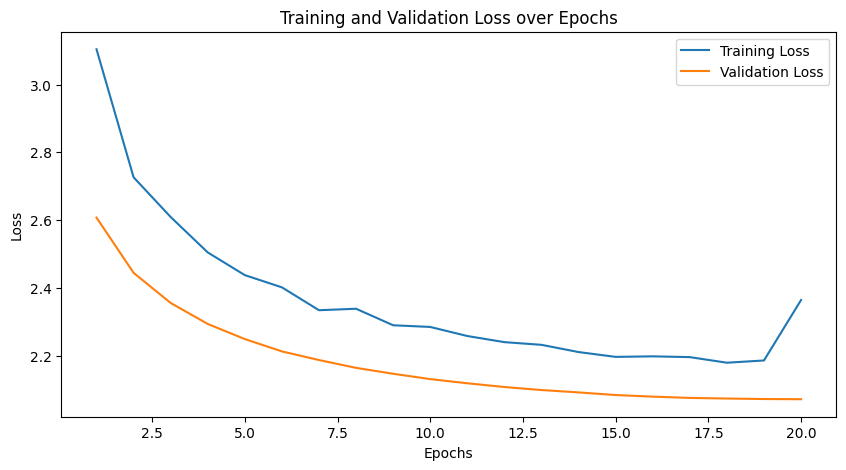

In [45]:
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

tr_losses = []
eval_losses = []
epochs = []

for log in training_logs:
    if 'loss' in log:
        tr_losses.append((log['epoch'], log['loss']))
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])
        epochs.append(log['epoch'])   
      
epoch_losses = {}
for epoch, loss in tr_losses:
    rounded_epoch = round(epoch)
    if rounded_epoch not in epoch_losses:
        epoch_losses[rounded_epoch] = []
    epoch_losses[rounded_epoch].append(loss)

smoothed_epoch_losses = {}
for k,v in epoch_losses.items():
    smoothed_epoch_losses[k] = np.mean(v)

final_epoch = [x for x in training_logs if 'train_loss' in x][0]
smoothed_epoch_losses[final_epoch['epoch']] = final_epoch['train_loss']

plt.figure(figsize=(10, 5))
plt.plot(epochs, smoothed_epoch_losses.values(), label='Training Loss')
plt.plot(epochs, eval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

In [49]:
tokenizer = AutoTokenizer.from_pretrained("../models/lexsum_model", low_cpu_mem_usage=True, device_map="auto")
model = AutoModelForSeq2SeqLM.from_pretrained("../models/lexsum_model", low_cpu_mem_usage=True, device_map="auto")

In [51]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer
)
predictions = trainer.predict(test_dataset=tokenized_test_dataset)

  0%|          | 0/227 [00:00<?, ?it/s]

In [53]:
rouge_metric = load_metric("rouge")

def decode(preds, labels):
    pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    label_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return pred_str, label_str

preds = predictions.predictions
labels = predictions.label_ids
pred_str, label_str = decode(preds, labels)

rouge_results = rouge_metric.compute(predictions=pred_str, references=label_str)
for key in rouge_results:
    print(f"{key}: {rouge_results[key].mid.fmeasure:.4f}")

rouge1: 0.1960
rouge2: 0.1055
rougeL: 0.1643
rougeLsum: 0.1644
